In [1]:
# from utils import *
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy.sparse.linalg as sla
import scipy.linalg as la
import scipy.sparse as sp
from scipy.constants import hbar, e, m_e, h
from types import SimpleNamespace
import tinyarray
import time

# Define a Haldane model

In [43]:
lat = kwant.lattice.honeycomb(a = 1.0, norbs=1)
a_lat, b_lat = lat.sublattices

nnn_hoppings_a = (((-1, 0), a_lat, a_lat), ((0, 1), a_lat, a_lat), ((1, -1), a_lat, a_lat))
nnn_hoppings_b = (((1, 0), b_lat, b_lat), ((0, -1), b_lat, b_lat), ((-1, 1), b_lat, b_lat))
nnn_hoppings_all = nnn_hoppings_a + nnn_hoppings_b
lat_neighbors_2 = [kwant.builder.HoppingKind(*hop) for hop in nnn_hoppings_all]

def onsite(site, param):
    return param.m if site.family == a_lat else -param.m
def nn_hopping(site1, site2, param):
    # x1, y1 = site1.pos
    # x2, y2 = site2.pos
    # return -np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2))
    return -1.0
def nnn_hopping(site1, site2, param):
    # x1, y1 = site1.pos
    # x2, y2 = site2.pos
    # return 1j*param.t_prime*np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2)) + param.t2
    return param.t2

# create system
sys = kwant.Builder()

# rectangle
Lx, Ly = 30, 35
sys[lat.shape(lambda pos: 0<=pos[0]<Lx and 0<=pos[1]<Ly, start = (0, 0))] = onsite

# circle
# r = 22
# sys[lat.shape(lambda pos: 0<= pos[0]*pos[0] + pos[1]*pos[1] < r*r, start = (0, 0))] = onsite

# triangle
# Lx = 10
# for i in range(0, Lx):
#     for j in range(0, Lx-i):
#         sys[a_lat(i, j)] = onsite
#         sys[b_lat(i, j)] = onsite

# ribbon 
# for i in range(0, Lx):
#     for j in range(0, Ly):
#         sys[a_lat(i, j)] = onsite
#         sys[b_lat(i, j)] = onsite

# hexagon
# Lx=25
# for i in range(0, 2*Lx):
#     if i < Lx:
#         for j in range(0, Lx):
#             sys[a_lat(i, j)] = onsite
#             sys[b_lat(i, j)] = onsite
#             if j > 0:
#                 sys[a_lat(i+j, -j)] = onsite
#                 sys[b_lat(i+j, -j)] = onsite
#     else:
#         for j in range(0, Lx - (i - Lx)):
#             sys[a_lat(i, j)] = onsite
#             sys[b_lat(i, j)] = onsite
#             if j > 0:
#                 sys[a_lat(i+j, -j)] = onsite
#                 sys[b_lat(i+j, -j)] = onsite

sys[lat.neighbors(n=1)] = nn_hopping

# Choose a specific site
sites = list(sys.sites())
# Count the number of connections (hopping terms) for the site
# make sure that no lattice point is connected to more than one site
for __ in range(2):
    sites = list(sys.sites())
    for s in sites:
        num_connections = sum(1 for _ in sys.neighbors(s))
        if num_connections == 1 or num_connections == 0: del sys[s]

sys[lat_neighbors_2] = nnn_hopping

sys = sys.finalized()


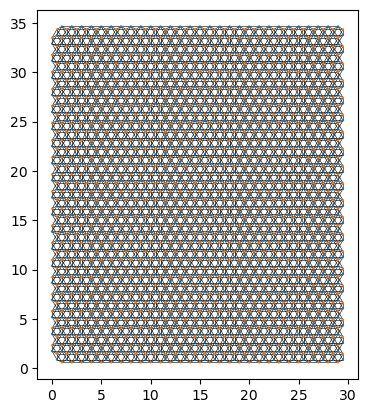

In [44]:
kwant.plot(sys, site_size=0.2, hop_lw=0.1, show=False)
plt.show()

## Bott index

In [45]:
def bott_index(sys, sys_params):
    h = sys.hamiltonian_submatrix(sparse=False, params=dict(param=sys_params))
    N = len(h)
    _, eigenvectors = np.linalg.eigh(h)
    eigenstates = eigenvectors.T
    # print("eigenvectors calculated")

    P = np.zeros([len(eigenstates[0]),len(eigenstates[0])], dtype=complex)
    # N_occ = binary_search(eigenvalues, 0.0)
    N_occ = N//2
    for i in range(N_occ):
        # P += np.array([eigenstates[i]]).T@np.array([eigenstates[i].conj()])
        P += np.outer(np.array([eigenstates[i]]).T, np.array([eigenstates[i].conj()]))

    # print("Fermi projector calculated")
    x_positions = np.array([s.pos[0] for s in sys.sites])
    x_norm = (x_positions-min(x_positions))/(max(x_positions)-min(x_positions))
    y_positions = np.array([s.pos[1] for s in sys.sites])
    y_norm = (y_positions-min(y_positions))/(max(y_positions)-min(y_positions))

    X = np.diag(x_norm)
    Y = np.diag(y_norm)

    pXp = P@X@P
    pYp = P@Y@P

    U = la.expm(1j*2*np.pi*pXp)
    V = la.expm(1j*2*np.pi*pYp)
    
    UVUdVd = U@V@np.conj(U.T)@np.conj(V.T)
    bott = np.imag(np.sum(np.log(np.linalg.eigvals(UVUdVd))))/2/np.pi
    return bott

In [46]:
print(bott_index(sys, SimpleNamespace(m=0.5953, t2=0.15*np.exp(-1j*np.pi/3), B=0.0)))

2.2757657880127567e-15


In [15]:
# system_parameters = SimpleNamespace(m = 0.64, t2 = 0.15*np.exp(-1j*np.pi/3))
system_parameters = SimpleNamespace(m = 0.0, t2 = 0.15*np.exp(-np.pi/3*1j))
m_l, m_r = 0.57 , 0.63
# print(bott_index(sys, SimpleNamespace(m = m_l, t2 = 0.15*np.exp(-np.pi/3*1j))), bott_index(sys, SimpleNamespace(m = m_r, t2 = 0.15*np.exp(-np.pi/3*1j))))
m_m = (m_l + m_r)/2
for i in range(10):
    system_parameters.m = m_m
    bott = bott_index(sys, system_parameters)
    print(f"ml= {m_l}, mr = {m_r}")
    print(f"m = {m_m}, bott index = {bott}")
    if bott < 0.5:
        m_r = m_m
    else:
        m_l = m_m
    m_m = (m_l + m_r)/2

ml= 0.57, mr = 0.63
m = 0.6, bott index = -5.054886731012387e-15
ml= 0.57, mr = 0.6
m = 0.585, bott index = 0.9999999999999999
ml= 0.585, mr = 0.6
m = 0.5925, bott index = 1.0000000000000087
ml= 0.5925, mr = 0.6
m = 0.59625, bott index = -2.5873866652394905e-15
ml= 0.5925, mr = 0.59625
m = 0.594375, bott index = 0.9999999999999867
ml= 0.594375, mr = 0.59625
m = 0.5953124999999999, bott index = 1.0
ml= 0.5953124999999999, mr = 0.59625
m = 0.5957812499999999, bott index = -4.709341036033356e-15
ml= 0.5953124999999999, mr = 0.5957812499999999
m = 0.5955468749999999, bott index = -1.1043036058806651e-14
ml= 0.5953124999999999, mr = 0.5955468749999999
m = 0.5954296874999999, bott index = -7.506071595125934e-15
ml= 0.5953124999999999, mr = 0.5954296874999999
m = 0.5953710937499999, bott index = -2.4219824060075327e-15


In [ ]:
print(m_m)
# 40x30, t2 = 0.15 exp(-i pi/3), m_c = 0.600615
# 35x30, t2 = 0.15 exp(-i pi/3), m_c = 0.5953417968749999
# 30x30, t2 = 0.15 exp(-i pi/3), m_c = 0.588076171875
# 30x20, t2 = 0.15 exp(-i pi/3), m_c = 0.572724609375
# 20x30, t2 = 0.15 exp(-i pi/3), m_c = 0.560537109375
# 15x30, t2 = 0.15 exp(-i pi/3), m_c = 0.5297167968750001
# 10x30, t2 = 0.15 exp(-i pi/3), m_c = 0.461572265625
# 7x30, t2 = 0.15 exp(-i pi/3), m_c = 0.369990234375
# 5x30, t2 = 0.15 exp(-i pi/3), m_c = 0.25321289062499996
critical_masses = [0.600615 ,0.59534 ,0.588076 ,0.560537 ,0.5297168 ,0.461572 ,0.36999 ,0.253213]
Lx_values = [40, 35, 30, 20, 15, 10, 7, 5]

# 30x40, t2 = 0.15 exp(-i pi/3), m_c = 0.5953417968749999
# 30x30, t2 = 0.15 exp(-i pi/3), m_c = 0.588076171875
# 30x25, t2 = 0.15 exp(-i pi/3), m_c = 0.5814550781250001
# 30x20, t2 = 0.15 exp(-i pi/3), m_c = 0.572724609375
# 30x15, t2 = 0.15 exp(-i pi/3), m_c = 0.5543261718750001
# 30x10, t2 = 0.15 exp(-i pi/3), m_c = 0.5140722656249999
# 30x7, t2 = 0.15 exp(-i pi/3), m_c = 0.472060546875
# 30x5, t2 = 0.15 exp(-i pi/3), m_c = 0.3911425781250001

critical_masses_2 = [0.391143, 0.472061, 0.5140723, 0.5543262, 0.57272, 0.581455, 0.588076, 0.5953418]
Ly_values = [5, 7, 10, 15, 20, 25, 30, 40]




# 25x20, t2 = 0.15 exp(-i pi/3), m_c = 0.5635839843750001
# 25x30, t2 = 0.15 exp(-i pi/3), m_c = 0.5635839843750001


# 30x15, t2=-0.02j, m_c = 0.07083984374999999
# 30x20, t2=-0.02j, m_c = 0.07224609374999999
# 30x25, t2=-0.02j, m_c = 0.0707
# 30x30, t2=-0.02j, m_c = 0.06955078125

0.5953417968749999


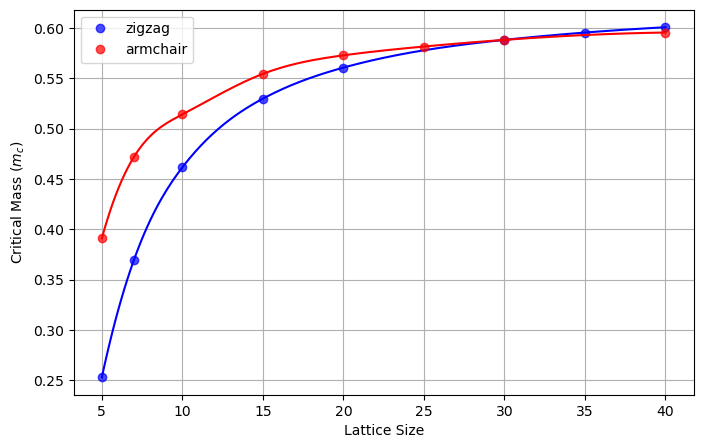

In [50]:
from scipy.interpolate import interp1d

# Interpolation for critical_masses (Lx_values vs critical_masses)
interp_Lx = np.linspace(min(Lx_values), max(Lx_values), 200)
f_Lx = interp1d(Lx_values, critical_masses, kind='cubic')
interp_critical_masses = f_Lx(interp_Lx)

# Interpolation and extrapolation for critical_masses_2 (Ly_values vs critical_masses_2)
interp_Ly = np.linspace(min(Ly_values), 40, 200)  # up to Ly=40 for extrapolation
f_Ly = interp1d(Ly_values, critical_masses_2, kind='cubic', fill_value='extrapolate')
interp_critical_masses_2 = f_Ly(interp_Ly)

plt.figure(figsize=(8, 5))
plt.plot(Lx_values, critical_masses, 'ob', label='zigzag', alpha=0.7)
plt.plot(interp_Lx, interp_critical_masses, '-b')
plt.plot(Ly_values, critical_masses_2, 'or', label='armchair', alpha=0.7)
plt.plot(interp_Ly, interp_critical_masses_2, '-r')
# plt.axvline(40, color='gray', linestyle='--', alpha=0.5, label='Ly=40')
plt.xlabel(r"Lattice Size")
plt.ylabel(r"Critical Mass ($m_c$)")
plt.legend()
plt.grid()
#plt.title("Interpolated and Extrapolated Critical Masses")
plt.savefig("critical_masses_interpolated.png", dpi=300)
plt.show()

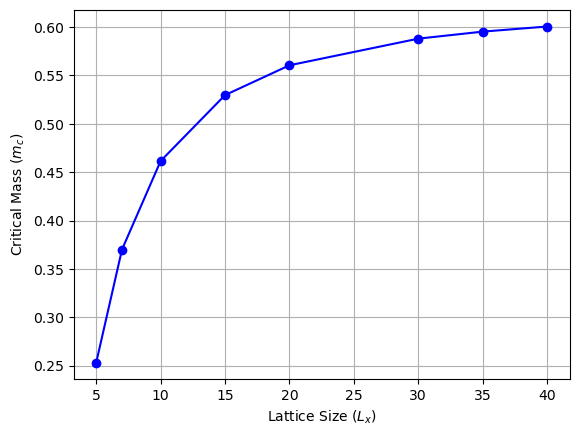

In [72]:
# plt.figure(figsize=(10, 10))
plt.plot(Lx_values, critical_masses, marker='o', linestyle='-', color='b')
# plt.title("Critical Mass vs Lattice Size")
plt.xlabel(r"Lattice Size ($L_x$)")
plt.ylabel(r"Critical Mass ($m_c$)")
plt.grid()
plt.savefig("bott_index_size-dep.png", dpi=300, bbox_inches='tight')
plt.show()